In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

In [10]:
train = pd.read_csv("data/reduced_train.csv")
test = pd.read_csv("data/reduced_test.csv")

In [11]:
X = train.drop('HeartDiseaseorAttack', axis = 1)
y = train['HeartDiseaseorAttack']

In [12]:
X = X.drop_duplicates()
y = y.loc[X.index]

In [13]:
X_test = test.drop('HeartDiseaseorAttack', axis = 1)
y_test = test['HeartDiseaseorAttack']

In [14]:
X_test = X_test.drop_duplicates()
y_test = y_test.loc[X_test.index]

In [15]:
transformer = SMOTE(sampling_strategy = 1)
X_under, y_under = transformer.fit_resample(X, y)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X_under, y_under, test_size = 0.1, stratify = y_under)

In [17]:
y_under.value_counts()

HeartDiseaseorAttack
0    109723
1    109723
Name: count, dtype: int64

In [18]:
#Applying Robust Scaler
transformer = RobustScaler()
Xscaled_train = transformer.fit_transform(X_train)
Xscaled_valid = transformer.transform(X_valid)
Xscaled_test = transformer.transform(X_test)

In [19]:
#converting to dataframes
Xscaled_train = pd.DataFrame(data = Xscaled_train, columns = X.columns)
Xscaled_valid = pd.DataFrame(data = Xscaled_valid, columns = X.columns)
Xscaled_test = pd.DataFrame(data = Xscaled_test, columns = X.columns)

In [20]:
#Apply pca
pca = PCA(n_components = 7)
Xpca_train = pca.fit_transform(Xscaled_train)
Xpca_valid = pca.transform(Xscaled_valid)
Xpca_test = pca.transform(Xscaled_test)

- PCA: Doesn't improve performance whatsoever

In [21]:
def evaluator(clf):
    clf.fit(X_train, y_train)
    raw = clf.predict_proba(X_test)[:, 1]
    threshold = 0.3
    pred = (raw >= threshold).astype(int)
    f1 = f1_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    temp = pd.Series(data = [f1, recall, precision], index = ['f1', 'recall', 'precision'])
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Predictions on test set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    print(temp)
    return pred, y_test

svc = SVC()
evaluator(svc)

In [22]:
from lightgbm import LGBMClassifier

f1           0.325159
recall       0.863388
precision    0.200296
dtype: float64


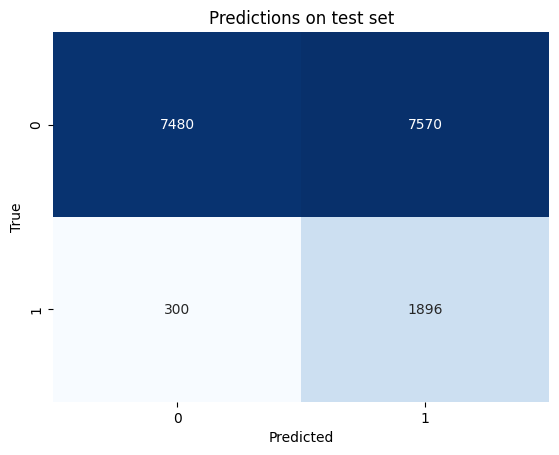

In [23]:
lg = LGBMClassifier(n_estimators = 1000, boosting_type = "goss", class_weight = 'balanced')
p,t = evaluator(lg)

## Error Analysis

In [359]:
p = pd.Series(data = p, index = t.index)

In [366]:
#Gather indices of false positives
FP = []
for i in t.index:
    if((t[i] == 0) & (p[i] == 1)):
        FP.append(i)

In [368]:
#Gather indices of false positives
TP = []
for i in t.index:
    if((t[i] == 1) & (p[i] == 1)):
        TP.append(i)

In [369]:
len(TP)

1882

In [370]:
len(FP)

6417

In [371]:
fp = X_test.loc[FP]
tp = X_test.loc[TP]

In [376]:
binary_col = [col for col in X_test.columns if X_test[col].nunique() == 2]
other_col = [col for col in X_test.columns if col not in binary_col]

['BMI', 'Diabetes', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']

In [378]:
print("For False Positives: ")
for col in binary_col:
    print(f"{col} percentage for 1s out of total: {round(sum(fp[col]) * 100 / len(fp[col]), 2)}")
for col in other_col:
    print(f"{col} average: {round(np.mean(fp[col]), 2)}")

For False Positives: 
HighBP percentage for 1s out of total: 70.16
HighChol percentage for 1s out of total: 60.39
Smoker percentage for 1s out of total: 52.81
Stroke percentage for 1s out of total: 8.27
PhysActivity percentage for 1s out of total: 52.89
DiffWalk percentage for 1s out of total: 34.95
BMI average: 29.89
Diabetes average: 0.67
GenHlth average: 3.23
MentHlth average: 5.04
PhysHlth average: 9.07
Age average: 10.12


In [379]:
print("For True Positives: ")
for col in binary_col:
    print(f"{col} percentage for 1s out of total: {round(sum(tp[col]) * 100 / len(tp[col]), 2)}")
for col in other_col:
    print(f"{col} average: {round(np.mean(tp[col]), 2)}")

For True Positives: 
HighBP percentage for 1s out of total: 79.65
HighChol percentage for 1s out of total: 74.18
Smoker percentage for 1s out of total: 63.97
Stroke percentage for 1s out of total: 19.34
PhysActivity percentage for 1s out of total: 57.12
DiffWalk percentage for 1s out of total: 50.0
BMI average: 29.73
Diabetes average: 0.8
GenHlth average: 3.61
MentHlth average: 5.28
PhysHlth average: 11.01
Age average: 10.53


- Distribution of false positive and true positives is very similar i.e why model is struggling to catch a difference and therfore the low precision and f1 scores

## Pickling the final model

In [28]:
#Creating the full dataset for final model
X_final = pd.concat([X, X_test], axis = 0)
y_final = pd.concat([y, y_test], axis = 0)

In [29]:
transformer = SMOTE(sampling_strategy = 1)
X_under, y_under = transformer.fit_resample(X_final, y_final)

In [30]:
import pickle
lg2 = LGBMClassifier(n_estimators = 1000, boosting_type = "goss", class_weight = 'balanced')
lg2.fit(X_under, y_under)

LGBMClassifier(boosting_type='goss', class_weight='balanced', n_estimators=1000)

In [31]:
pickle.dump(lg2, open("clf.pkl", "wb"))